INFORMASI DATASET
Jumlah data: 200 baris, 6 kolom

Kolom: ['student_id', 'hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores', 'exam_score']

Sample data:
  student_id  hours_studied  sleep_hours  attendance_percent  previous_scores  \
0       S001            8.0          8.8                72.1               45   
1       S002            1.3          8.6                60.7               55   
2       S003            4.0          8.2                73.7               86   
3       S004            3.5          4.8                95.1               66   
4       S005            9.1          6.4                89.8               71   

   exam_score  
0        30.2  
1        25.0  
2        35.8  
3        34.0  
4        40.3  

STATISTIK DESKRIPTIF
       hours_studied  sleep_hours  attendance_percent  previous_scores  \
count     200.000000   200.000000          200.000000       200.000000   
mean        6.325500     6.622000           74.830000        66.800000   

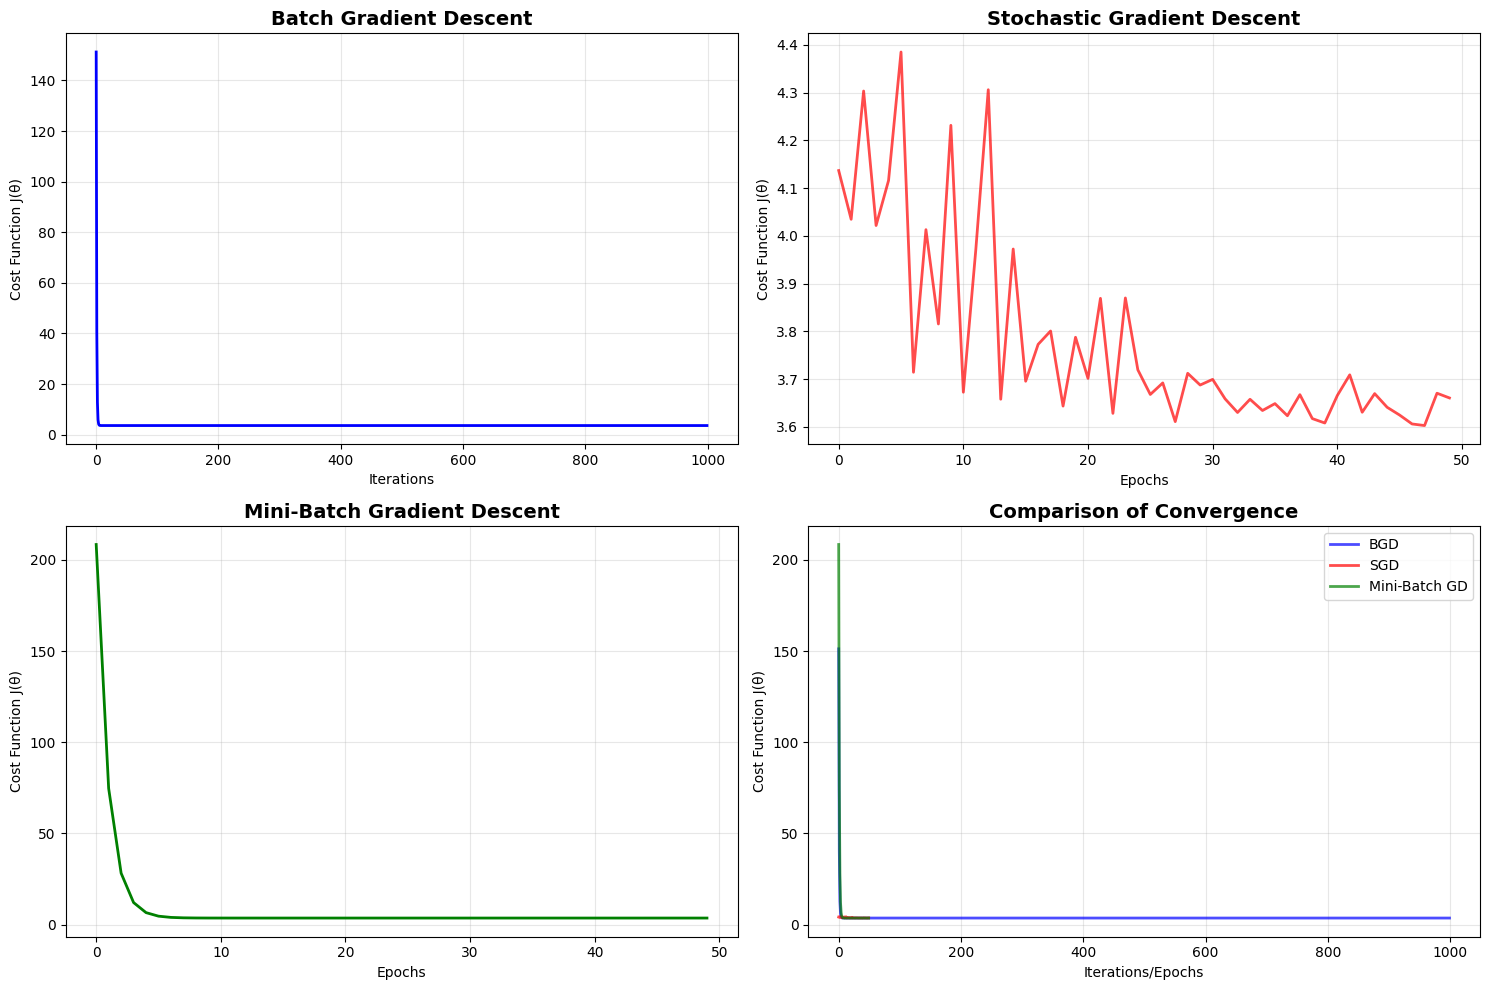

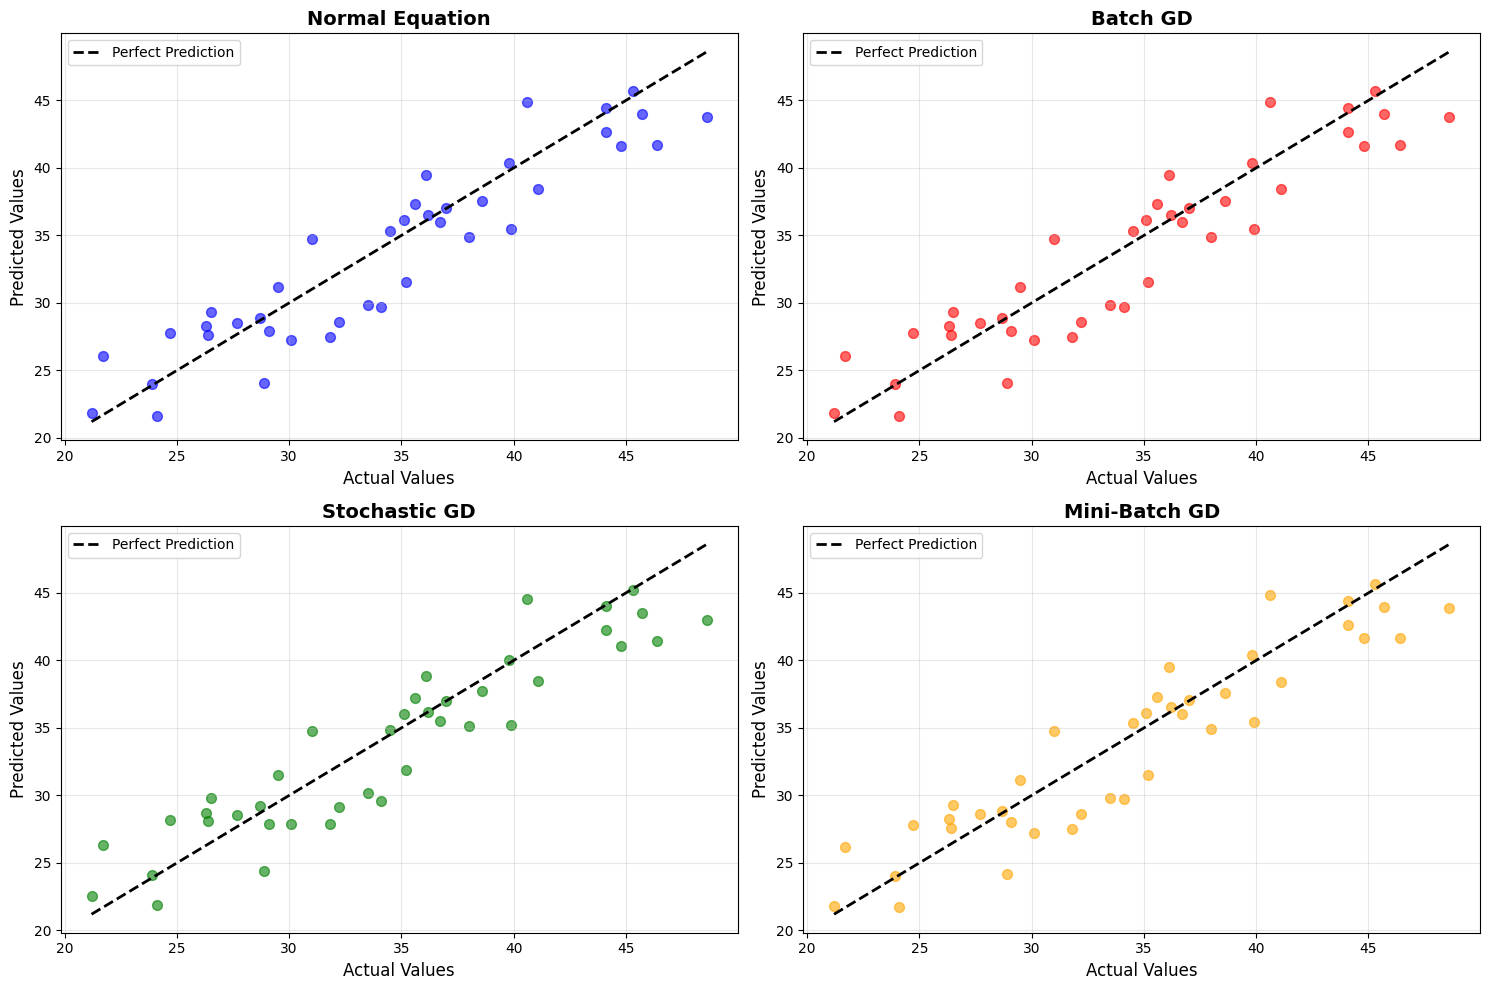

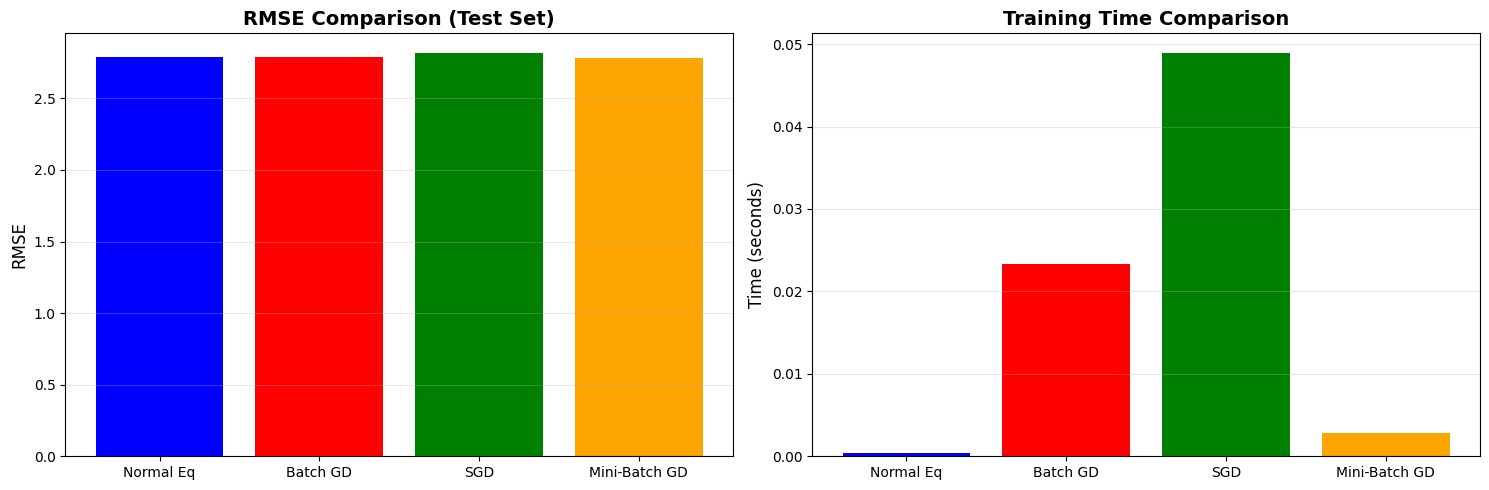


IMPLEMENTASI SELESAI!

Grafik telah disimpan:
  1. convergence_comparison.png
  2. predictions_comparison.png
  3. metrics_comparison.png


In [4]:
"""
IMPLEMENTASI REGRESI LINIER MULTIVARIAT
4 Metode: Normal Equation, BGD, SGD, dan Mini-Batch GD
Dataset: Student Exam Scores
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
np.random.seed(42)

# ===============================================
# 1. LOAD DAN PREPROCESSING DATA
# ===============================================

# Load dataset
df = pd.read_csv('/home/wgg/Downloads/student_exam_scores.csv')

print("="*60)
print("INFORMASI DATASET")
print("="*60)
print(f"Jumlah data: {df.shape[0]} baris, {df.shape[1]} kolom")
print(f"\nKolom: {list(df.columns)}")
print(f"\nSample data:")
print(df.head())

# Statistik deskriptif
print("\n" + "="*60)
print("STATISTIK DESKRIPTIF")
print("="*60)
print(df.describe())

# Memisahkan fitur (X) dan target (y)
X = df[['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']].values
y = df['exam_score'].values

print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Feature Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tambahkan bias term (intercept) - kolom dengan nilai 1
X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

print(f"\nShape setelah menambahkan bias term:")
print(f"X_train_b: {X_train_b.shape}")
print(f"X_test_b: {X_test_b.shape}")


# ===============================================
# 2. FUNGSI HELPER
# ===============================================

def compute_cost(X, y, theta):
    """
    Menghitung Cost Function (MSE)
    J(θ) = (1/2m) * Σ(h(x) - y)²
    """
    m = len(y)
    predictions = X.dot(theta)
    errors = predictions - y
    cost = (1/(2*m)) * np.sum(errors**2)
    return cost

def compute_gradient(X, y, theta):
    """
    Menghitung gradient dari cost function
    ∇J(θ) = (1/m) * X^T * (X*θ - y)
    """
    m = len(y)
    predictions = X.dot(theta)
    errors = predictions - y
    gradient = (1/m) * X.T.dot(errors)
    return gradient

def predict(X, theta):
    """Prediksi nilai y"""
    return X.dot(theta)

def evaluate_model(X, y, theta, model_name):
    """Evaluasi performa model"""
    predictions = predict(X, theta)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)

    print(f"\n{model_name} - Evaluation Metrics:")
    print(f"  MSE  : {mse:.4f}")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  R²   : {r2:.4f}")

    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 'predictions': predictions}


# ===============================================
# 3. METODE 1: NORMAL EQUATION
# ===============================================

print("\n" + "="*60)
print("METODE 1: NORMAL EQUATION")
print("="*60)

def normal_equation(X, y):
    """
    Menghitung parameter optimal menggunakan Normal Equation
    θ = (X^T * X)^(-1) * X^T * y
    """
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return theta

# Training dengan Normal Equation
start_time = time.time()
theta_normal = normal_equation(X_train_b, y_train)
training_time_normal = time.time() - start_time

print(f"\nWaktu komputasi: {training_time_normal:.6f} detik")
print(f"\nParameter optimal (θ):")
print(f"  θ0 (intercept): {theta_normal[0]:.4f}")
for i in range(1, len(theta_normal)):
    feature_names = ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']
    print(f"  θ{i} ({feature_names[i-1]}): {theta_normal[i]:.4f}")

# Evaluasi
results_normal_train = evaluate_model(X_train_b, y_train, theta_normal, "Normal Equation (Training)")
results_normal_test = evaluate_model(X_test_b, y_test, theta_normal, "Normal Equation (Testing)")


# ===============================================
# 4. METODE 2: BATCH GRADIENT DESCENT (BGD)
# ===============================================

print("\n" + "="*60)
print("METODE 2: BATCH GRADIENT DESCENT")
print("="*60)

def batch_gradient_descent(X, y, learning_rate=0.01, n_iterations=1000):
    """
    Implementasi Batch Gradient Descent
    Update: θ = θ - α * ∇J(θ)
    """
    m, n = X.shape
    theta = np.zeros(n)  # Inisialisasi parameter dengan 0
    cost_history = []

    for iteration in range(n_iterations):
        # Hitung gradient menggunakan SELURUH training set
        gradient = compute_gradient(X, y, theta)

        # Update parameter
        theta = theta - learning_rate * gradient

        # Simpan cost
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)

        # Print progress setiap 100 iterasi
        if iteration % 100 == 0:
            print(f"  Iterasi {iteration:4d}: Cost = {cost:.4f}")

    return theta, cost_history

# Grid search untuk learning rate optimal
learning_rates = [0.001, 0.01, 0.1, 0.5]
print("\nMencari learning rate optimal...")

best_lr = None
best_final_cost = float('inf')

for lr in learning_rates:
    theta_temp, cost_temp = batch_gradient_descent(
        X_train_b, y_train, learning_rate=lr, n_iterations=100
    )
    final_cost = cost_temp[-1]
    print(f"Learning rate {lr}: Final cost = {final_cost:.4f}")

    if final_cost < best_final_cost:
        best_final_cost = final_cost
        best_lr = lr

print(f"\nLearning rate optimal: {best_lr}")

# Training dengan BGD menggunakan learning rate optimal
print(f"\nTraining dengan BGD (learning rate = {best_lr})...")
start_time = time.time()
theta_bgd, cost_history_bgd = batch_gradient_descent(
    X_train_b, y_train, learning_rate=best_lr, n_iterations=1000
)
training_time_bgd = time.time() - start_time

print(f"\nWaktu komputasi: {training_time_bgd:.6f} detik")
print(f"\nParameter optimal (θ):")
print(f"  θ0 (intercept): {theta_bgd[0]:.4f}")
for i in range(1, len(theta_bgd)):
    feature_names = ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']
    print(f"  θ{i} ({feature_names[i-1]}): {theta_bgd[i]:.4f}")

# Evaluasi
results_bgd_train = evaluate_model(X_train_b, y_train, theta_bgd, "BGD (Training)")
results_bgd_test = evaluate_model(X_test_b, y_test, theta_bgd, "BGD (Testing)")


# ===============================================
# 5. METODE 3: STOCHASTIC GRADIENT DESCENT (SGD)
# ===============================================

print("\n" + "="*60)
print("METODE 3: STOCHASTIC GRADIENT DESCENT")
print("="*60)

def sgd(X, y, learning_rate=0.01, n_epochs=50, learning_schedule=True):
    """
    Implementasi Stochastic Gradient Descent
    Update parameter berdasarkan SATU sample pada setiap iterasi
    """
    m, n = X.shape
    theta = np.zeros(n)
    cost_history = []

    for epoch in range(n_epochs):
        # Shuffle data setiap epoch
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(m):
            # Ambil satu sample
            xi = X_shuffled[i:i+1]
            yi = y_shuffled[i:i+1]

            # Learning rate schedule (menurun seiring iterasi)
            if learning_schedule:
                t = epoch * m + i
                lr = learning_rate / (1 + t/1000)
            else:
                lr = learning_rate

            # Hitung gradient untuk satu sample
            gradient = compute_gradient(xi, yi, theta)

            # Update parameter
            theta = theta - lr * gradient

        # Hitung cost setiap epoch (menggunakan seluruh data)
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)

        if epoch % 10 == 0:
            print(f"  Epoch {epoch:3d}: Cost = {cost:.4f}, LR = {lr:.6f}")

    return theta, cost_history

# Training dengan SGD
print("\nTraining dengan SGD (dengan learning rate schedule)...")
start_time = time.time()
theta_sgd, cost_history_sgd = sgd(
    X_train_b, y_train, learning_rate=0.1, n_epochs=50, learning_schedule=True
)
training_time_sgd = time.time() - start_time

print(f"\nWaktu komputasi: {training_time_sgd:.6f} detik")
print(f"\nParameter optimal (θ):")
print(f"  θ0 (intercept): {theta_sgd[0]:.4f}")
for i in range(1, len(theta_sgd)):
    feature_names = ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']
    print(f"  θ{i} ({feature_names[i-1]}): {theta_sgd[i]:.4f}")

# Evaluasi
results_sgd_train = evaluate_model(X_train_b, y_train, theta_sgd, "SGD (Training)")
results_sgd_test = evaluate_model(X_test_b, y_test, theta_sgd, "SGD (Testing)")


# ===============================================
# 6. METODE 4: MINI-BATCH GRADIENT DESCENT
# ===============================================

print("\n" + "="*60)
print("METODE 4: MINI-BATCH GRADIENT DESCENT")
print("="*60)

def mini_batch_gd(X, y, learning_rate=0.01, n_epochs=50, batch_size=32):
    """
    Implementasi Mini-Batch Gradient Descent
    Update parameter berdasarkan mini-batch
    """
    m, n = X.shape
    theta = np.zeros(n)
    cost_history = []

    for epoch in range(n_epochs):
        # Shuffle data setiap epoch
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Iterasi melalui mini-batches
        for i in range(0, m, batch_size):
            # Ambil mini-batch
            xi = X_shuffled[i:i+batch_size]
            yi = y_shuffled[i:i+batch_size]

            # Hitung gradient untuk mini-batch
            gradient = compute_gradient(xi, yi, theta)

            # Update parameter
            theta = theta - learning_rate * gradient

        # Hitung cost setiap epoch
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)

        if epoch % 10 == 0:
            print(f"  Epoch {epoch:3d}: Cost = {cost:.4f}")

    return theta, cost_history

# Mencoba berbagai ukuran batch
batch_sizes = [16, 32, 64]
print("\nMencari ukuran batch optimal...")

best_batch_size = None
best_final_cost_mb = float('inf')

for bs in batch_sizes:
    theta_temp, cost_temp = mini_batch_gd(
        X_train_b, y_train, learning_rate=0.1, n_epochs=20, batch_size=bs
    )
    final_cost = cost_temp[-1]
    print(f"Batch size {bs}: Final cost = {final_cost:.4f}")

    if final_cost < best_final_cost_mb:
        best_final_cost_mb = final_cost
        best_batch_size = bs

print(f"\nBatch size optimal: {best_batch_size}")

# Training dengan Mini-Batch GD
print(f"\nTraining dengan Mini-Batch GD (batch size = {best_batch_size})...")
start_time = time.time()
theta_mbgd, cost_history_mbgd = mini_batch_gd(
    X_train_b, y_train, learning_rate=0.1, n_epochs=50, batch_size=best_batch_size
)
training_time_mbgd = time.time() - start_time

print(f"\nWaktu komputasi: {training_time_mbgd:.6f} detik")
print(f"\nParameter optimal (θ):")
print(f"  θ0 (intercept): {theta_mbgd[0]:.4f}")
for i in range(1, len(theta_mbgd)):
    feature_names = ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']
    print(f"  θ{i} ({feature_names[i-1]}): {theta_mbgd[i]:.4f}")

# Evaluasi
results_mbgd_train = evaluate_model(X_train_b, y_train, theta_mbgd, "Mini-Batch GD (Training)")
results_mbgd_test = evaluate_model(X_test_b, y_test, theta_mbgd, "Mini-Batch GD (Testing)")


# ===============================================
# 7. KOMPARASI DAN VISUALISASI
# ===============================================

print("\n" + "="*60)
print("RINGKASAN KOMPARASI METODE")
print("="*60)

# Tabel komparasi
comparison_data = {
    'Metode': ['Normal Equation', 'Batch GD', 'Stochastic GD', 'Mini-Batch GD'],
    'Waktu (detik)': [training_time_normal, training_time_bgd, training_time_sgd, training_time_mbgd],
    'RMSE Train': [results_normal_train['rmse'], results_bgd_train['rmse'],
                   results_sgd_train['rmse'], results_mbgd_train['rmse']],
    'RMSE Test': [results_normal_test['rmse'], results_bgd_test['rmse'],
                  results_sgd_test['rmse'], results_mbgd_test['rmse']],
    'R² Train': [results_normal_train['r2'], results_bgd_train['r2'],
                 results_sgd_train['r2'], results_mbgd_train['r2']],
    'R² Test': [results_normal_test['r2'], results_bgd_test['r2'],
                results_sgd_test['r2'], results_mbgd_test['r2']]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))


# ===============================================
# 8. VISUALISASI
# ===============================================

# Plot 1: Convergence of Cost Function
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# BGD
axes[0, 0].plot(cost_history_bgd, 'b-', linewidth=2)
axes[0, 0].set_title('Batch Gradient Descent', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Iterations')
axes[0, 0].set_ylabel('Cost Function J(θ)')
axes[0, 0].grid(True, alpha=0.3)

# SGD
axes[0, 1].plot(cost_history_sgd, 'r-', linewidth=2, alpha=0.7)
axes[0, 1].set_title('Stochastic Gradient Descent', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Cost Function J(θ)')
axes[0, 1].grid(True, alpha=0.3)

# Mini-Batch GD
axes[1, 0].plot(cost_history_mbgd, 'g-', linewidth=2)
axes[1, 0].set_title('Mini-Batch Gradient Descent', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Cost Function J(θ)')
axes[1, 0].grid(True, alpha=0.3)

# Comparison of all methods
axes[1, 1].plot(cost_history_bgd, 'b-', label='BGD', linewidth=2, alpha=0.7)
axes[1, 1].plot(cost_history_sgd, 'r-', label='SGD', linewidth=2, alpha=0.7)
axes[1, 1].plot(cost_history_mbgd, 'g-', label='Mini-Batch GD', linewidth=2, alpha=0.7)
axes[1, 1].set_title('Comparison of Convergence', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Iterations/Epochs')
axes[1, 1].set_ylabel('Cost Function J(θ)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Prediction vs Actual (Testing Set)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

methods = [
    ('Normal Equation', theta_normal, 'blue'),
    ('Batch GD', theta_bgd, 'red'),
    ('Stochastic GD', theta_sgd, 'green'),
    ('Mini-Batch GD', theta_mbgd, 'orange')
]

for idx, (method_name, theta, color) in enumerate(methods):
    ax = axes[idx // 2, idx % 2]
    predictions = predict(X_test_b, theta)

    ax.scatter(y_test, predictions, alpha=0.6, color=color, s=50)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
            'k--', lw=2, label='Perfect Prediction')
    ax.set_xlabel('Actual Values', fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=12)
    ax.set_title(f'{method_name}', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# RMSE Comparison
methods_names = ['Normal Eq', 'Batch GD', 'SGD', 'Mini-Batch GD']
rmse_values = [results_normal_test['rmse'], results_bgd_test['rmse'],
               results_sgd_test['rmse'], results_mbgd_test['rmse']]

axes[0].bar(methods_names, rmse_values, color=['blue', 'red', 'green', 'orange'])
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('RMSE Comparison (Test Set)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Training Time Comparison
time_values = [training_time_normal, training_time_bgd,
               training_time_sgd, training_time_mbgd]

axes[1].bar(methods_names, time_values, color=['blue', 'red', 'green', 'orange'])
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("IMPLEMENTASI SELESAI!")
print("="*60)
print("\nGrafik telah disimpan:")
print("  1. convergence_comparison.png")
print("  2. predictions_comparison.png")
print("  3. metrics_comparison.png")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
